In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### Regression problem
Given the number of passengers this month, what is the number of passengers next month?

#### References:
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* https://medium.com/@matthew1992/time-series-with-lstm-090cb8d16a59

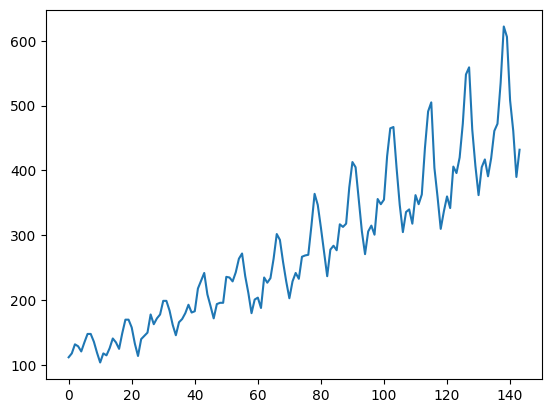

In [2]:
SEED = 42
DATASET_PATH = 'data/airline-passengers.csv'
dataset = pd.read_csv(DATASET_PATH, 
                      usecols=[1], 
                      engine='python')
plt.plot(dataset)
plt.show()

In [45]:
dataset = dataset.astype('float32') # more suitable for neural networks
#print(dataset)
# Normalize data because LSTMs are sensitive to the scale of the input data
# Specifically because activation functions like sigmoid and tanh are 
# sensitive to the scale of the input data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
labels = np.roll(dataset, -1, axis=0)
labels[-1, :] = 0.6758 # Invent likely value for last label
#print(labels)

In [46]:
# Split dataset while keeping the order of the data
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
X_train, X_test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
y_train, y_test = labels[0:train_size,:], labels[train_size:len(dataset),:]
print(len(X_train), len(X_test))

100 44


In [47]:
train_data = torch.FloatTensor(X_train).unsqueeze(1)
test_data = torch.FloatTensor(X_test).unsqueeze(1)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

train_dataset = TensorDataset(train_data, y_train)
test_dataset = TensorDataset(test_data, y_test)

BATCH_SIZE = 64  # You can adjust the batch size
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [48]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.init_hidden(batch_size)
        lstm_out, hidden = self.lstm(input, hidden)
        output = self.fc(lstm_out[:, -1, :])
        return output
    
    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_size),
                torch.zeros(1, batch_size, self.hidden_size))

In [56]:
print(len(train_data))

# Define the hyperparameters
input_size = train_data.size(2) # Number of features
hidden_size = 256
output_size = 1 # Number of values to output for each input
learning_rate = 0.01
num_epochs = 200
# Instantiate the model
model = LSTM(input_size, hidden_size, output_size)
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
model.train()

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Zero out gradients to prevent accumulating with previous iterations
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        loss.backward()
        # Updates weights and biases parameters
        optimizer.step()
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

100
Epoch [1/200], Step [1/2], Loss: 0.0551
Epoch [1/200], Step [2/2], Loss: 0.0410
Epoch [2/200], Step [1/2], Loss: 0.0180
Epoch [2/200], Step [2/2], Loss: 0.0204
Epoch [3/200], Step [1/2], Loss: 0.0303
Epoch [3/200], Step [2/2], Loss: 0.0214
Epoch [4/200], Step [1/2], Loss: 0.0196
Epoch [4/200], Step [2/2], Loss: 0.0149
Epoch [5/200], Step [1/2], Loss: 0.0148
Epoch [5/200], Step [2/2], Loss: 0.0234
Epoch [6/200], Step [1/2], Loss: 0.0192
Epoch [6/200], Step [2/2], Loss: 0.0194
Epoch [7/200], Step [1/2], Loss: 0.0154
Epoch [7/200], Step [2/2], Loss: 0.0126
Epoch [8/200], Step [1/2], Loss: 0.0126
Epoch [8/200], Step [2/2], Loss: 0.0123
Epoch [9/200], Step [1/2], Loss: 0.0124
Epoch [9/200], Step [2/2], Loss: 0.0151
Epoch [10/200], Step [1/2], Loss: 0.0109
Epoch [10/200], Step [2/2], Loss: 0.0094
Epoch [11/200], Step [1/2], Loss: 0.0078
Epoch [11/200], Step [2/2], Loss: 0.0077
Epoch [12/200], Step [1/2], Loss: 0.0080
Epoch [12/200], Step [2/2], Loss: 0.0102
Epoch [13/200], Step [1/2], Lo

In [57]:
predictions = []
actuals = []

model.eval() # So that the model doesn't do backpropagation

test_loss = 0.0
with torch.no_grad(): # Disable gradient calculation
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model(inputs)
        predictions.extend(outputs.view(-1).tolist())
        actuals.extend(labels.view(-1).tolist())
        loss = criterion(outputs, labels)
        test_loss += loss.item()
    # Compute the evaluation metrics
    avg_test_loss = test_loss / len(test_loader)
    print('Average Test Loss: {:.4f}'.format(avg_test_loss))

Average Test Loss: 0.0090


[0.47707027196884155, 0.5919010043144226, 0.6633949875831604, 0.6666795015335083, 0.5614674687385559, 0.4630725085735321, 0.38855859637260437, 0.4437239170074463, 0.4507733881473541, 0.4118075370788574, 0.48926761746406555, 0.4648256003856659, 0.4910062253475189, 0.6136937737464905, 0.7058154940605164, 0.7284102439880371, 0.5614674687385559, 0.48404598236083984, 0.3975203335285187, 0.44548773765563965, 0.4857874810695648, 0.45429229736328125, 0.5648639798164368, 0.5478441119194031, 0.588534414768219, 0.6748750805854797, 0.7967520356178284, 0.8139834403991699, 0.6601069569587708, 0.5665608048439026, 0.48926761746406555, 0.5631662011146545, 0.5834774971008301, 0.5392988920211792, 0.5868496298789978, 0.6568152904510498, 0.6748750805854797, 0.7762565612792969, 0.9107660055160522, 0.8864889144897461, 0.7332296967506409, 0.6568152904510498, 0.53758704662323, 0.60867840051651]
[0.6138995885848999, 0.6969112157821655, 0.7007721662521362, 0.5791505575180054, 0.46911194920539856, 0.3880308568477

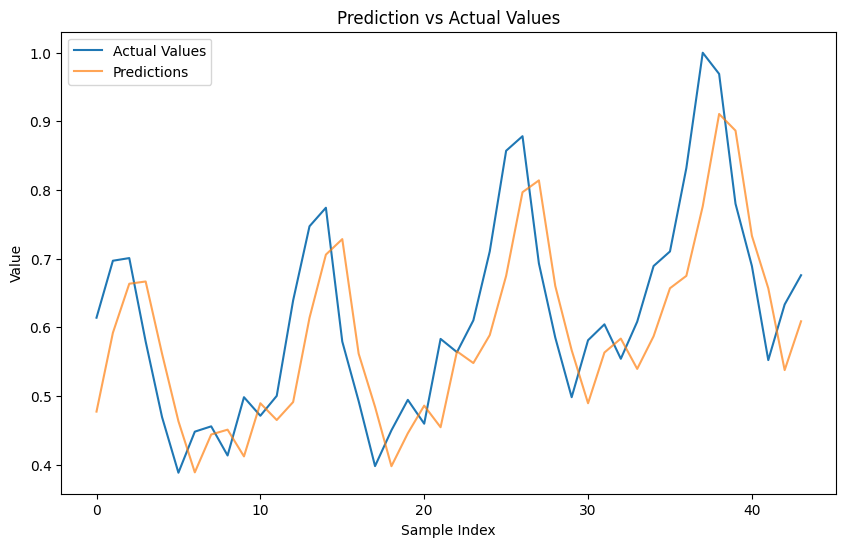

In [58]:
print(predictions)
print(actuals)

plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(actuals, label='Actual Values')  # Plot the actual values
plt.plot(predictions, label='Predictions', alpha=0.7)  # Plot the predictions
plt.title('Prediction vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

### Pretty close!
Would probabably use longer data to get better predictions